# Looking at the kinematic properties of stars as a function of age, rotation period and color.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from dispersion import binned_dispersion
from color_conversions import teff_to_bv
from stardate.lhf import gyro_model

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 20,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [3]:
gaia_mc = pd.read_csv("gaia_mc.csv")

Calculate B-V color and Angus + (2015) ages.

In [4]:
bv = teff_to_bv(gaia_mc.teff)
gaia_mc["B-V"] = bv

def angus_age_gyr(prot, bv):
    a, b, c, n = [.4, .31, .45, .55]
    return (prot/(a*(bv - c)**b))**(1./n)*1e-3

gaia_mc["angus_age"] = angus_age_gyr(gaia_mc.Prot, gaia_mc["B-V"])

Select stars based on temperature first.

In [14]:
def select_stars(df, bins, column_name):
    """
    Select groups of stars, based on bins.
    
    Args:
        df (pandas.DataFrame): a pandas dataframe.
        bins (array): The list or array of bin edges.
        column_name (str): The name of the column to cut on.
        
    Returns:
        ms (list): a list of masks to select stars with.
    
    """
    
    ms = []
    for i in range(len(bins)-1):
        m = (df["{}".format(column_name)] > bins[i]) * (df["{}".format(column_name)] < bins[i+1])
        ms.append(m)
        
    return ms

# TEST
df = pd.DataFrame(dict({"A": np.arange(10), "B": np.arange(10, 20)}))
ms = select_stars(df, [1, 5, 8], "A")
assert np.all(df.A.values[ms[0]] > 1)
assert np.all(df.A.values[ms[0]] < 5)
assert np.all(df.A.values[ms[1]] < 8)
assert np.all(df.A.values[ms[1]] > 5)

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


(6200, 3000)

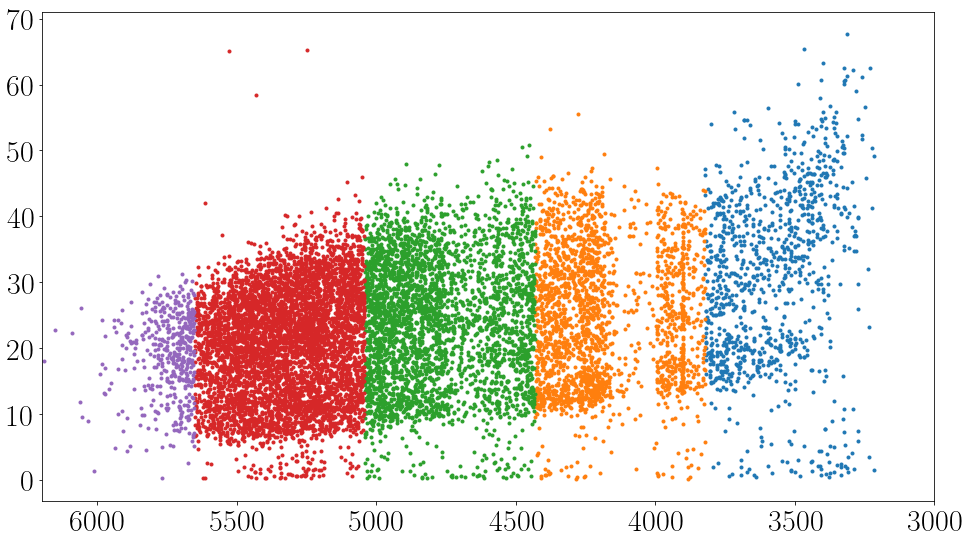

In [25]:
teff_bins = np.linspace(min(gaia_mc.teff), max(gaia_mc.teff), 6)
ms = select_stars(gaia_mc, teff_bins, "teff")


plt.figure(figsize=(16, 9), dpi=200)
for m in ms:
    plt.plot(gaia_mc.teff.values[m], gaia_mc.Prot.values[m], ".")
    
plt.xlim(6200, 3000)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabe

In [5]:
def select_plot(tmin, tmax, plot=True):
    m = (gaia_mc.Teff > tmin) * (gaia_mc.Teff < tmax)
    print(sum(m), "stars")

    if plot:
        plt.figure(figsize=(16, 9), dpi=200)
    
        # all stars
        plt.plot(gaia_mc.Teff, gaia_mc.Prot, "k.", alpha=.1, zorder=0, mec="none", ms=10,
                 label="$\mathrm{All~non-visual~binary~dwarfs}$", rasterized=True)
    
        # Selected stars
        plt.plot(gaia_mc.Teff[m], gaia_mc.Prot[m], "k.", alpha=.5, zorder=0, mec="none", ms=10,
                 label="_nolegend_", rasterized=True)

        # Sun
        plt.scatter(5778, 26, facecolors='w', edgecolors="k", s=200, zorder=3, rasterized=True)
        plt.plot(5778, 26, "k.", zorder=3, rasterized=True)
    
        # fill between
        ymin, ymax = 3, 70
        xs = np.linspace(tmin, tmax, 100)
        plt.fill_between(xs, ymin, ymax, zorder=1, alpha=.2, color=".3")
    
        plt.xlim(6300, 3000)
        plt.xlabel("$\mathrm{T_{eff}~[K]}$")
        plt.ylabel("$\mathrm{P_{rot}~[days]}$")
        plt.yscale("log")
        plt.ylim(ymin, ymax)
        plt.legend()
    return m

In [6]:
def velocity_plot(m, nbins=10, plot=True):

    bins, dbins, err, mean = binned_dispersion(gaia_mc.Prot.values[m], gaia_mc.v_b.values[m], nbins, method="std")

    if plot:
        plt.figure(figsize=(16, 9), dpi=200)
        plt.scatter(gaia_mc.Prot[m], gaia_mc.v_b[m], c=gaia_mc.age[m])
        plt.colorbar(label="$\mathrm{Age~[Gyr]}$")
        plt.xlabel("$\mathrm{P_{rot}~[days]}$")
        plt.ylabel("$\mathrm{V_b~[mas/yr]}$")
        plt.axhline(0, color="k", ls="--", label="$\mathrm{V_b = 0}$")
        plt.step(bins, dbins, where="mid", lw=2, color="k")
        plt.errorbar(bins, dbins, yerr=err, fmt=".", color="k", ms=1)
        plt.axvline(7, color="k", ls="-.", label="$\mathrm{Binary~limit}$")
    return bins, dbins, err

In [7]:
teff_ranges = [6100, 5200, 4800, 4300, 3950, 3600, 3000]

In [8]:
m = select_plot(teff_ranges[1], teff_ranges[0], plot=False)
m &= gaia_mc.log_age.values > 8.5
m &= gaia_mc.Prot.values < 40  # Cutting out pesky subgiants
bins0, dbins0, err0 = velocity_plot(m, nbins=8, plot=False)
print(max(dbins0))

2609 stars
19.805640145967033


/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [9]:
m1 = select_plot(teff_ranges[2], teff_ranges[1], plot=False)
m1 &= gaia_mc.Prot.values < 40  # Cutting out pesky subgiants
bins1, dbins1, err1 = velocity_plot(m1, nbins=8, plot=False)
print(max(dbins1))

4183 stars
20.5585862905953


In [10]:
m2 = select_plot(teff_ranges[3], teff_ranges[2], plot=False)
m2 &= gaia_mc.Prot.values < 45  # Cutting out pesky subgiants
bins2, dbins2, err2 = velocity_plot(m2, nbins=8, plot=False)
print(max(dbins2))

2702 stars
20.481893022563206


In [11]:
m3 = select_plot(teff_ranges[4], teff_ranges[3], plot=False)
bins3, dbins3, err3 = velocity_plot(m3, nbins=8, plot=False)
print(max(dbins3))

1666 stars
24.41102102854038


In [12]:
m4 = select_plot(teff_ranges[5], teff_ranges[4], plot=False)
bins4, dbins4, err4 = velocity_plot(m4, nbins=8, plot=False)
print(max(dbins4))

920 stars
33.68099749465767


In [13]:
m5 = select_plot(teff_ranges[6], teff_ranges[5], plot=False)
bins5, dbins5, err5 = velocity_plot(m5, nbins=8, plot=False)
print(max(dbins5))

551 stars
26.982054446823685


In [14]:
# m6 = select_plot(teff_ranges[7], teff_ranges[6], plot=False)
# bins6, dbins6 = velocity_plot(m6, plot=False)
# print(max(dbins6))

In [15]:
# m7 = select_plot(teff_ranges[8], teff_ranges[7], plot=False)
# bins7, dbins7 = velocity_plot(m7, plot=False)
# print(max(dbins7))

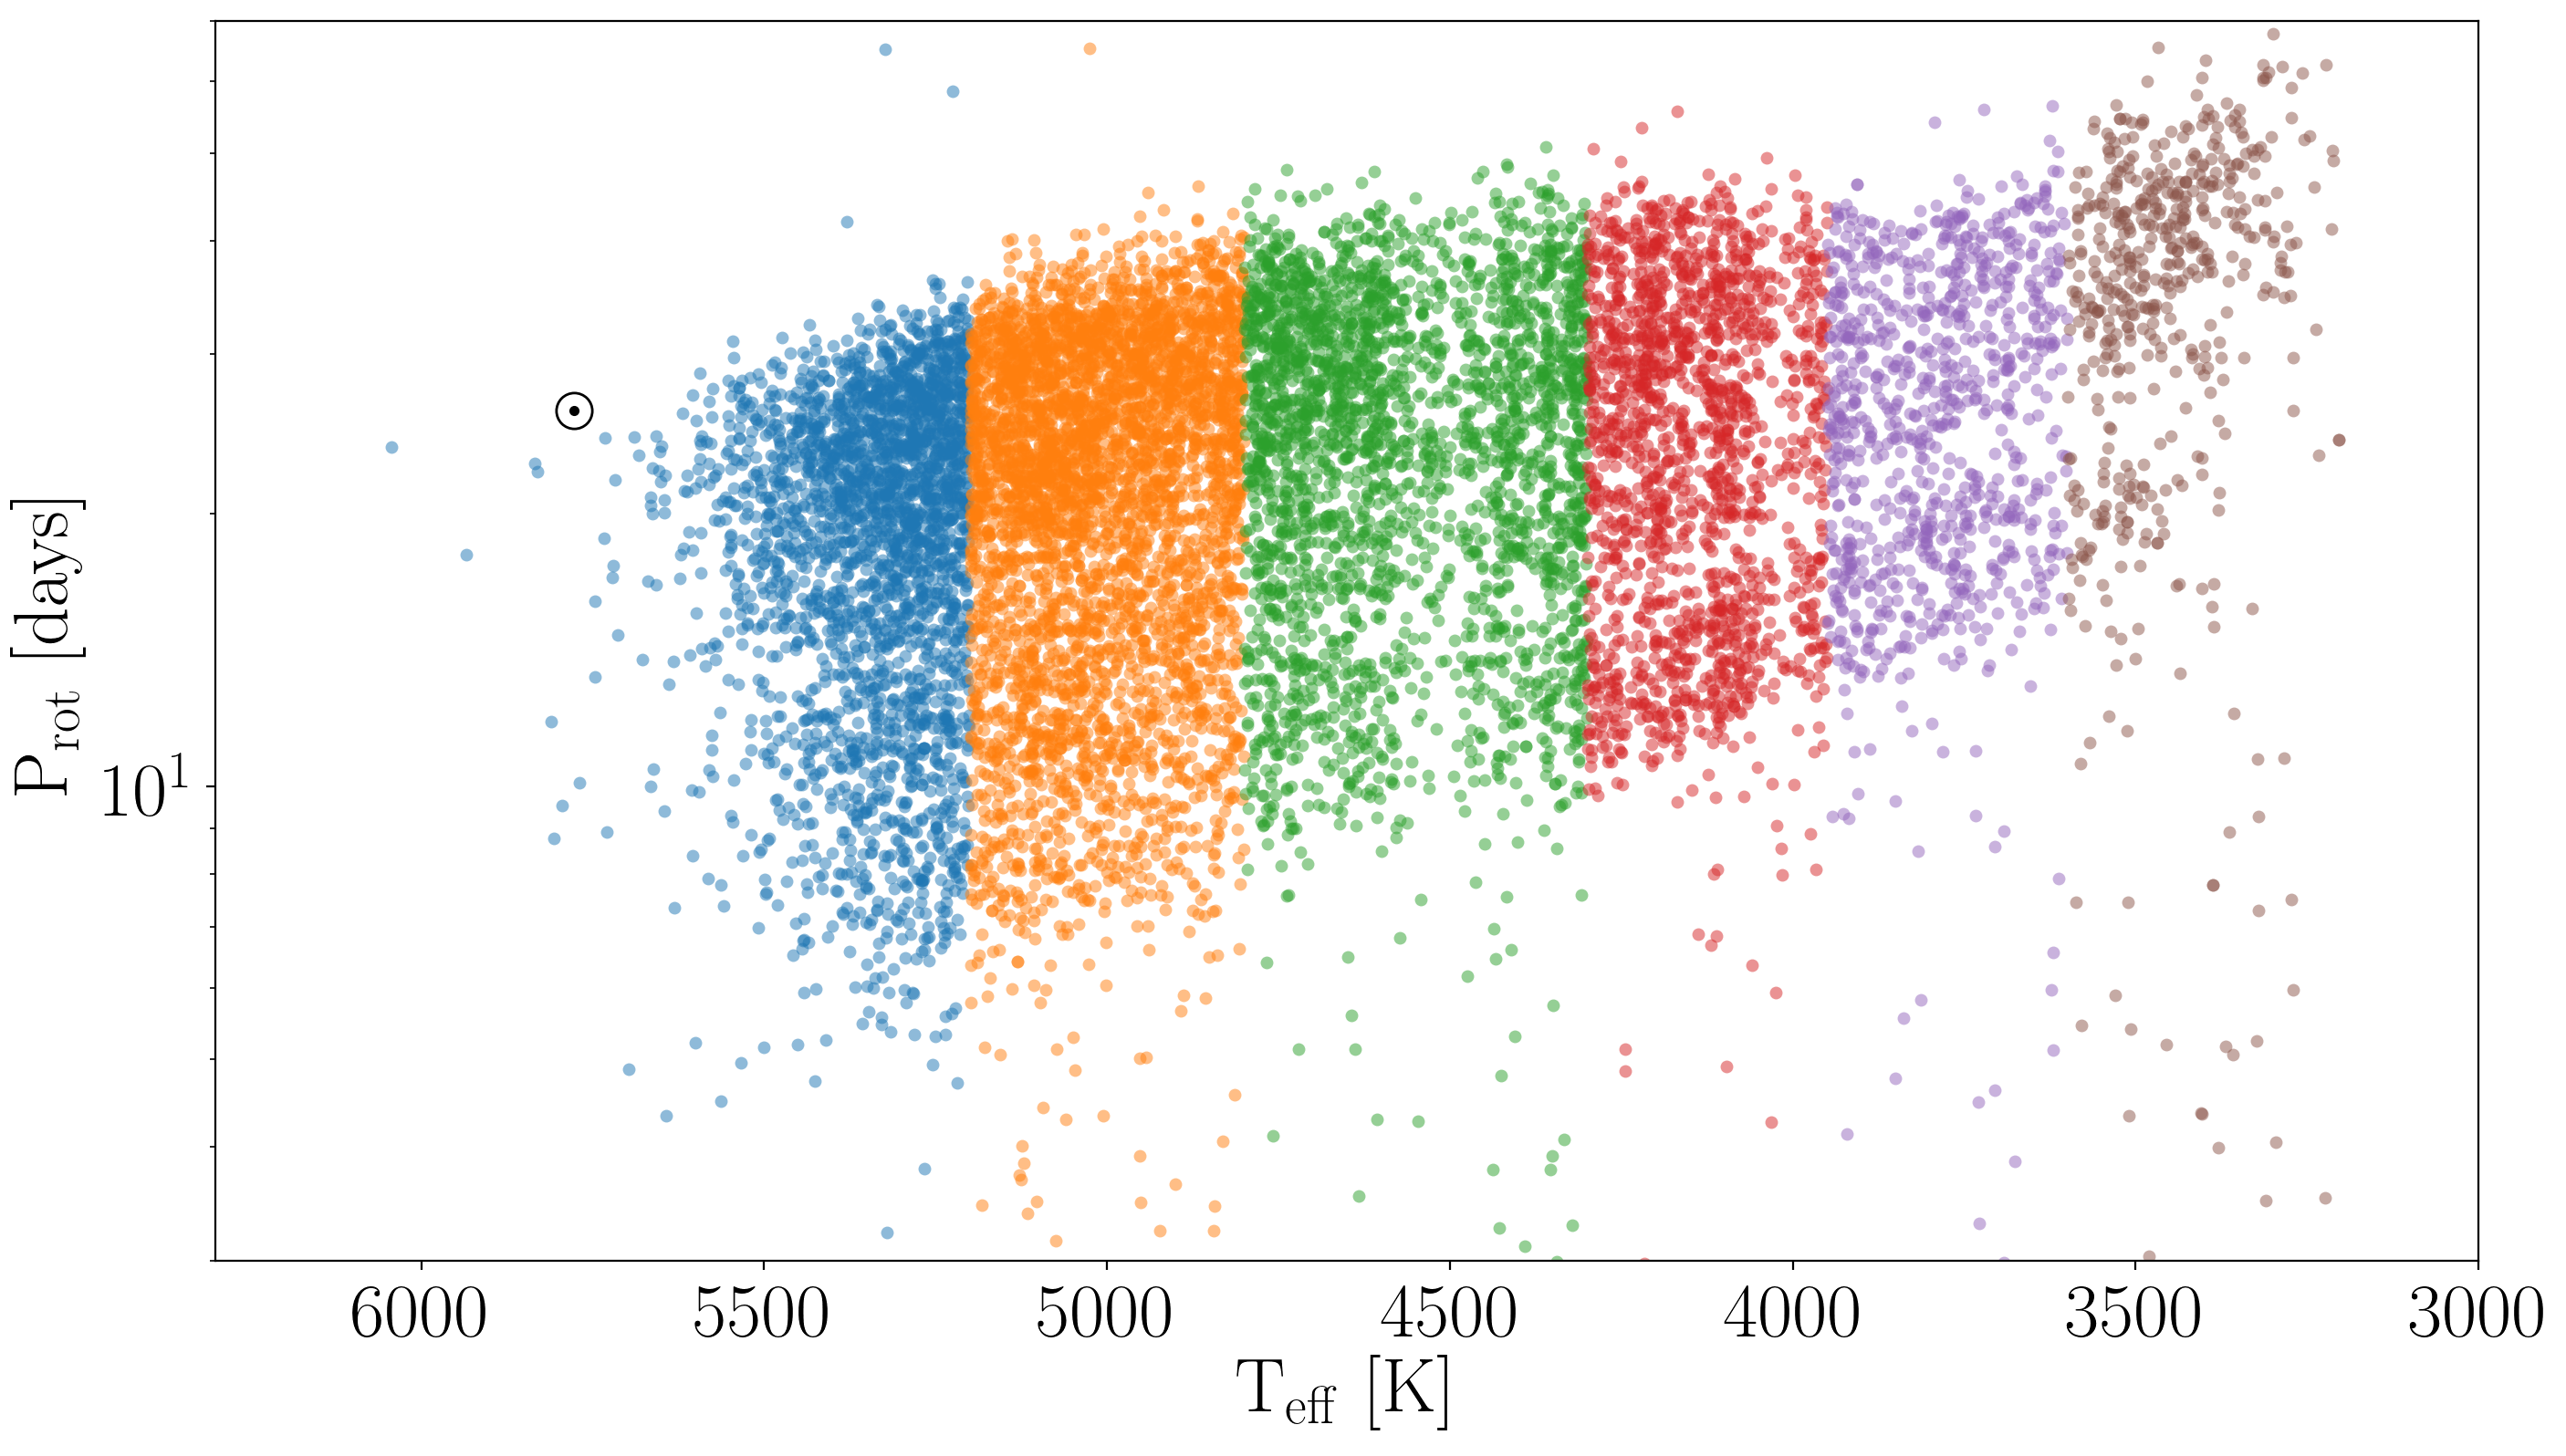

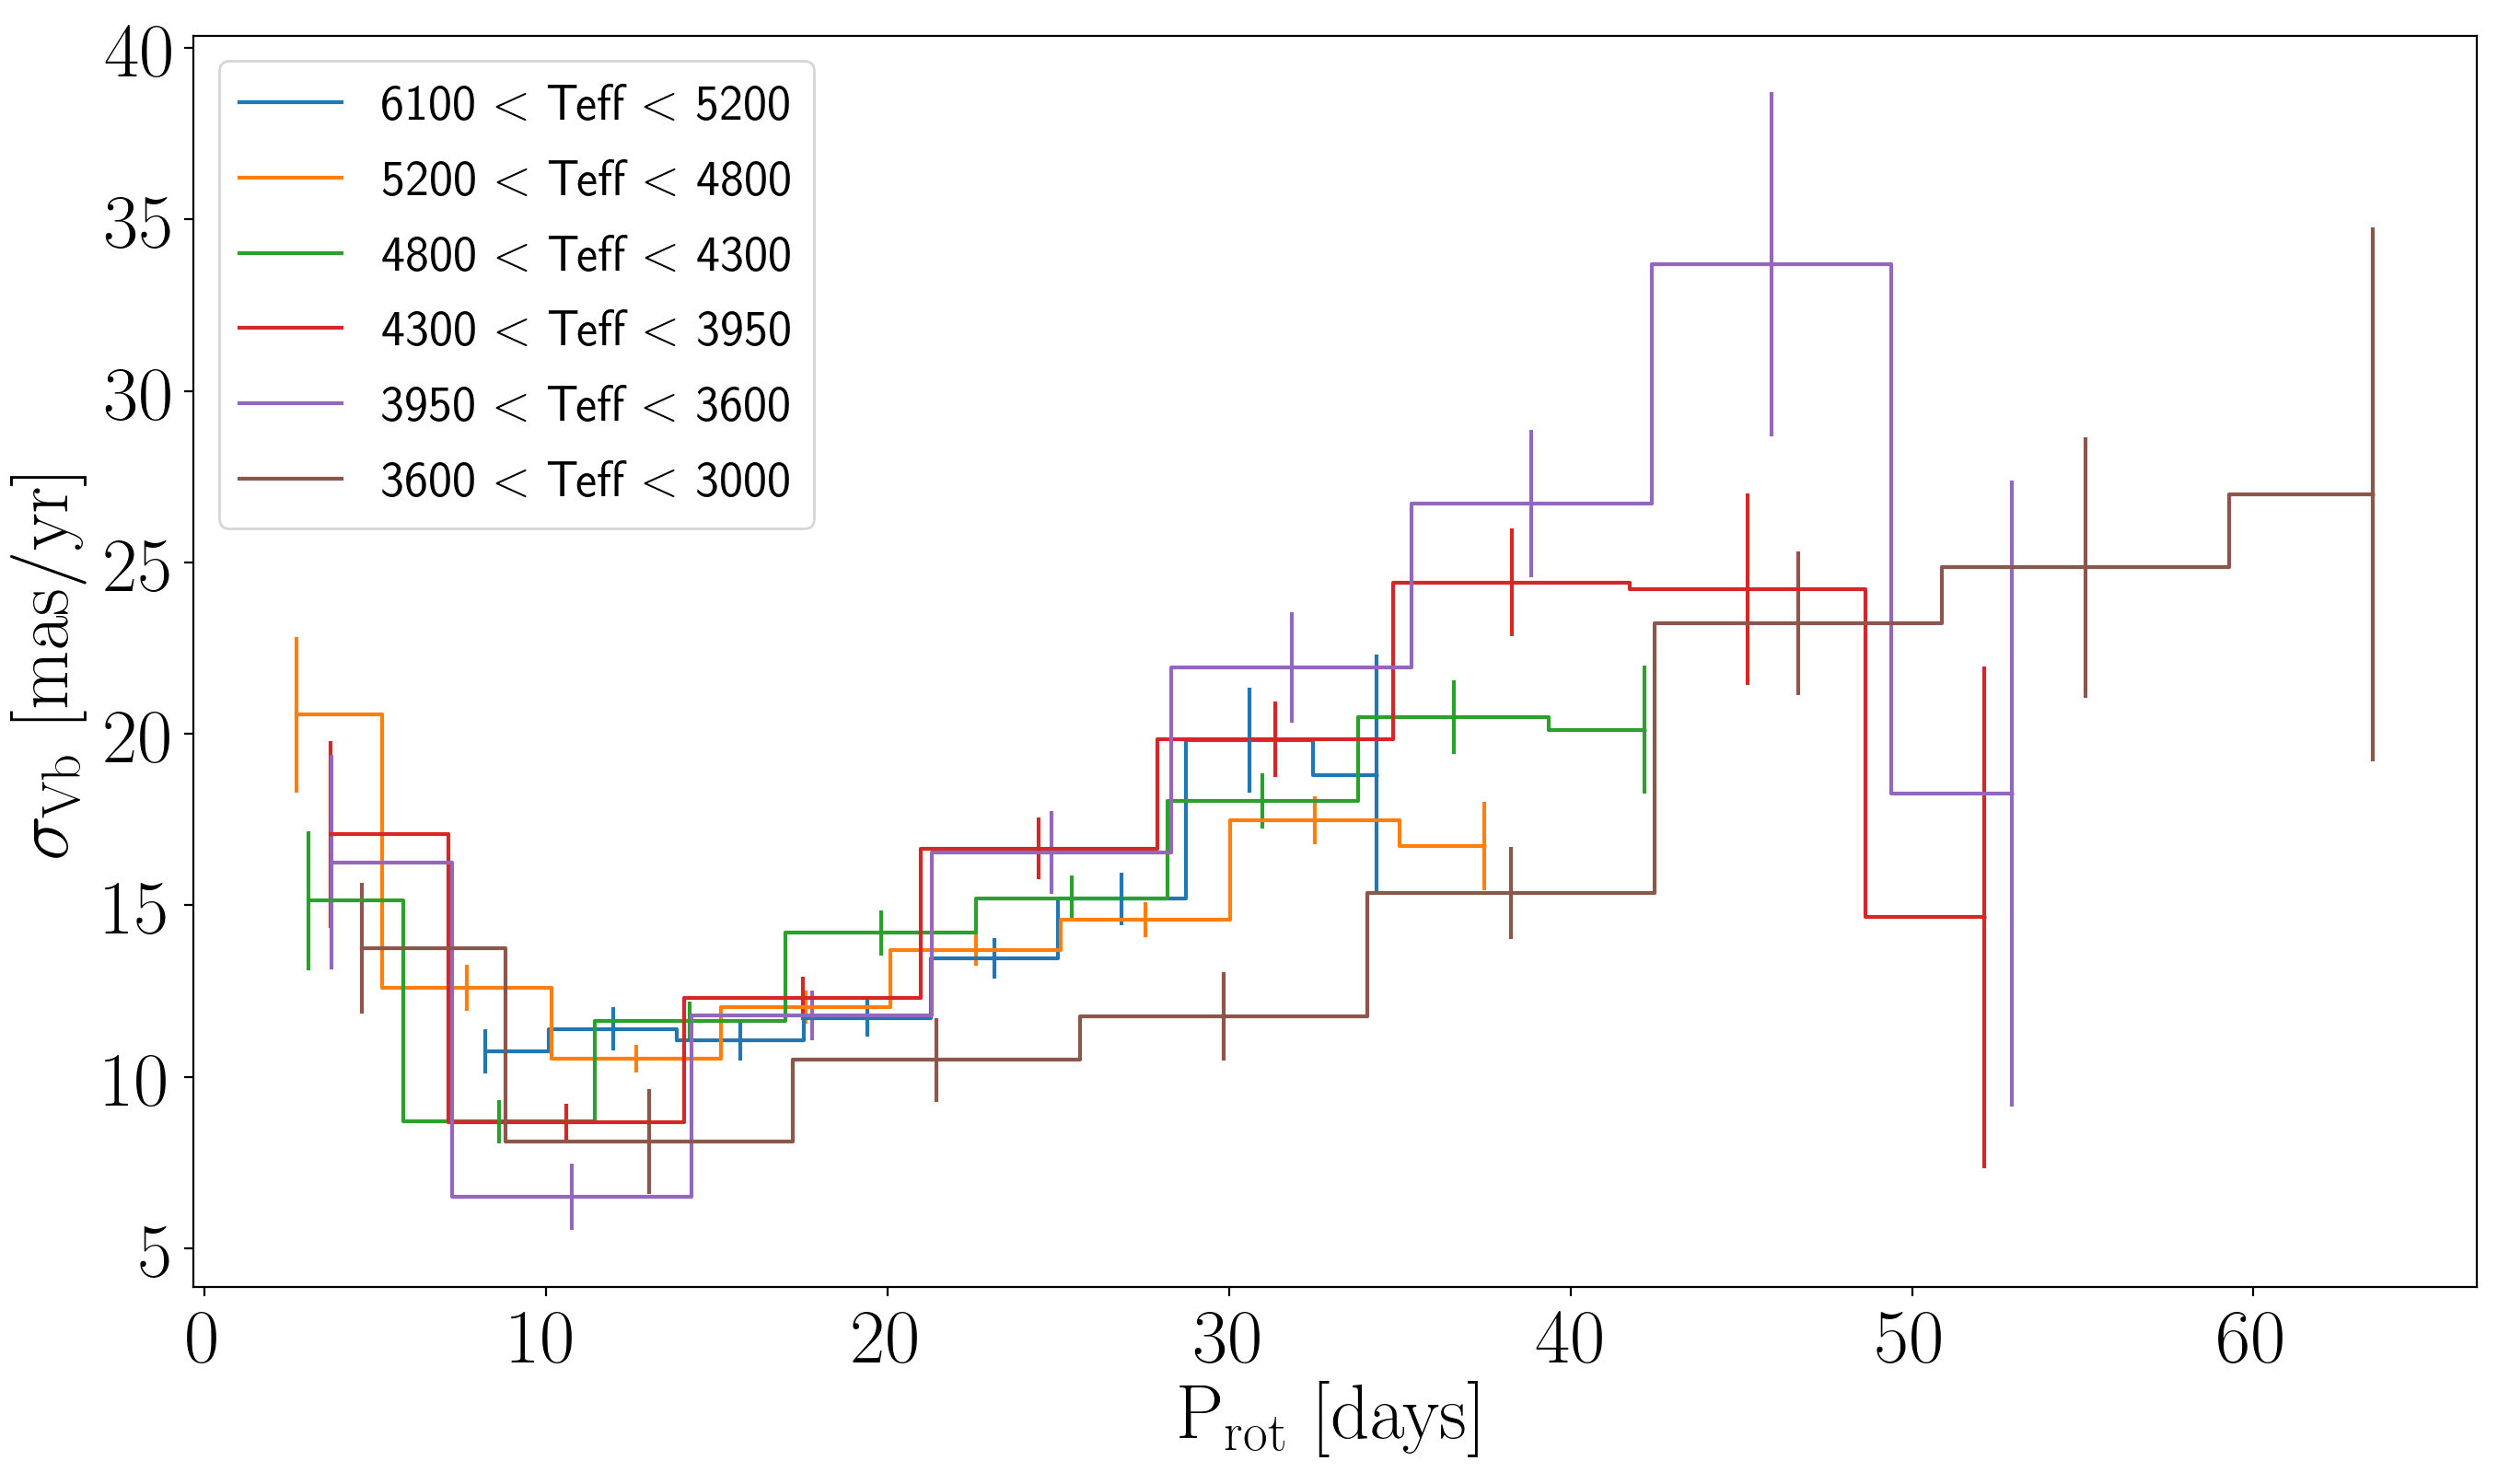

In [16]:
plt.figure(figsize=(16, 9), dpi=200)
for i in range(len(teff_ranges)-1):
    m = (gaia_mc.Teff < teff_ranges[i]) * (gaia_mc.Teff > teff_ranges[i+1])

    # Selected stars
    plt.plot(gaia_mc.Teff[m], gaia_mc.Prot[m], ".", alpha=.5, zorder=0, mec="none", ms=10,
             label="_nolegend_", rasterized=True)

# Sun
plt.scatter(5778, 26, facecolors='w', edgecolors="k", s=200, zorder=3, rasterized=True)
plt.plot(5778, 26, "k.", zorder=3, rasterized=True)
    
    
plt.xlim(6300, 3000)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.yscale("log")
plt.ylim(3, 70)
# plt.legend()

def plot_step(bins, dbins, teff_ranges):
    plt.figure(figsize=(16, 9), dpi=200)
    for i in range(len(bins)):
        plt.step(bins[i], dbins[i], color="C{}".format(i), where="mid",
                 label="{0} $<$ Teff $<$ {1}".format(teff_ranges[i], teff_ranges[i+1]))
        plt.errorbar(bins[i], dbins[i], yerr=err[i], fmt=".", color="C{}".format(i), ms=1)
    plt.legend()
    plt.xlabel("$\mathrm{P_{rot}~[days]}$")
    plt.ylabel("$\mathrm{\sigma_{Vb}~[mas/yr]}$")

bins = [bins0, bins1, bins2, bins3, bins4, bins5]
dbins = [dbins0, dbins1, dbins2, dbins3, dbins4, dbins5]
err = [err0, err1, err2, err3, err4, err5]
plot_step(bins, dbins, teff_ranges)

In [17]:
def select_on_age(amin, amax, plot=True, method="praesepe"):
    if method == "praesepe":
        m = (gaia_mc.age > amin) * (gaia_mc.age < amax)
    elif method == "angus":
        m = (gaia_mc.age > amin) * (gaia_mc.age < amax)
    elif method == "prot":
        m = (gaia_mc.Prot > amin) * (gaia_mc.Prot < amax)
    print(sum(m), "stars")

    if plot:
        plt.figure(figsize=(16, 9), dpi=200)
    
        # all stars
        plt.plot(gaia_mc.Teff, gaia_mc.Prot, "k.", alpha=.1, zorder=0, mec="none", ms=10,
                 label="$\mathrm{All~non-visual~binary~dwarfs}$", rasterized=True)
    
        # Selected stars
        plt.plot(gaia_mc.Teff[m], gaia_mc.Prot[m], "k.", alpha=.5, zorder=0, mec="none", ms=10,
                 label="_nolegend_", rasterized=True)

        # Sun
        plt.scatter(5778, 26, facecolors='w', edgecolors="k", s=200, zorder=3, rasterized=True)
        plt.plot(5778, 26, "k.", zorder=3, rasterized=True)
    
        plt.xlim(6300, 3000)
        plt.xlabel("$\mathrm{T_{eff}~[K]}$")
        plt.ylabel("$\mathrm{P_{rot}~[days]}$")
        plt.yscale("log")
        plt.ylim(3, 70)
        plt.legend()
    return m

In [18]:
age_ranges = [.5, .7, 1., 1.5, 2., 3., 4., 5.]
age_ranges = [8, 12, 15, 20, 25, 30, 40, 60]
# age_ranges = [8, 15, 20, 30, 60]

method = "prot"
m0 = select_on_age(age_ranges[0], age_ranges[1], plot=False, method=method)
m1 = select_on_age(age_ranges[1], age_ranges[2], plot=False, method=method)
m2 = select_on_age(age_ranges[2], age_ranges[3], plot=False, method=method)
m3 = select_on_age(age_ranges[3], age_ranges[4], plot=False, method=method)
m4 = select_on_age(age_ranges[4], age_ranges[5], plot=False, method=method)
m5 = select_on_age(age_ranges[5], age_ranges[6], plot=False, method=method)
m6 = select_on_age(age_ranges[6], age_ranges[7], plot=False, method=method)

abins, adbins, aerr = velocity_plot(m0, nbins=8, plot=False)

1225 stars
1192 stars
2063 stars
2410 stars
2201 stars
2438 stars
562 stars


/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


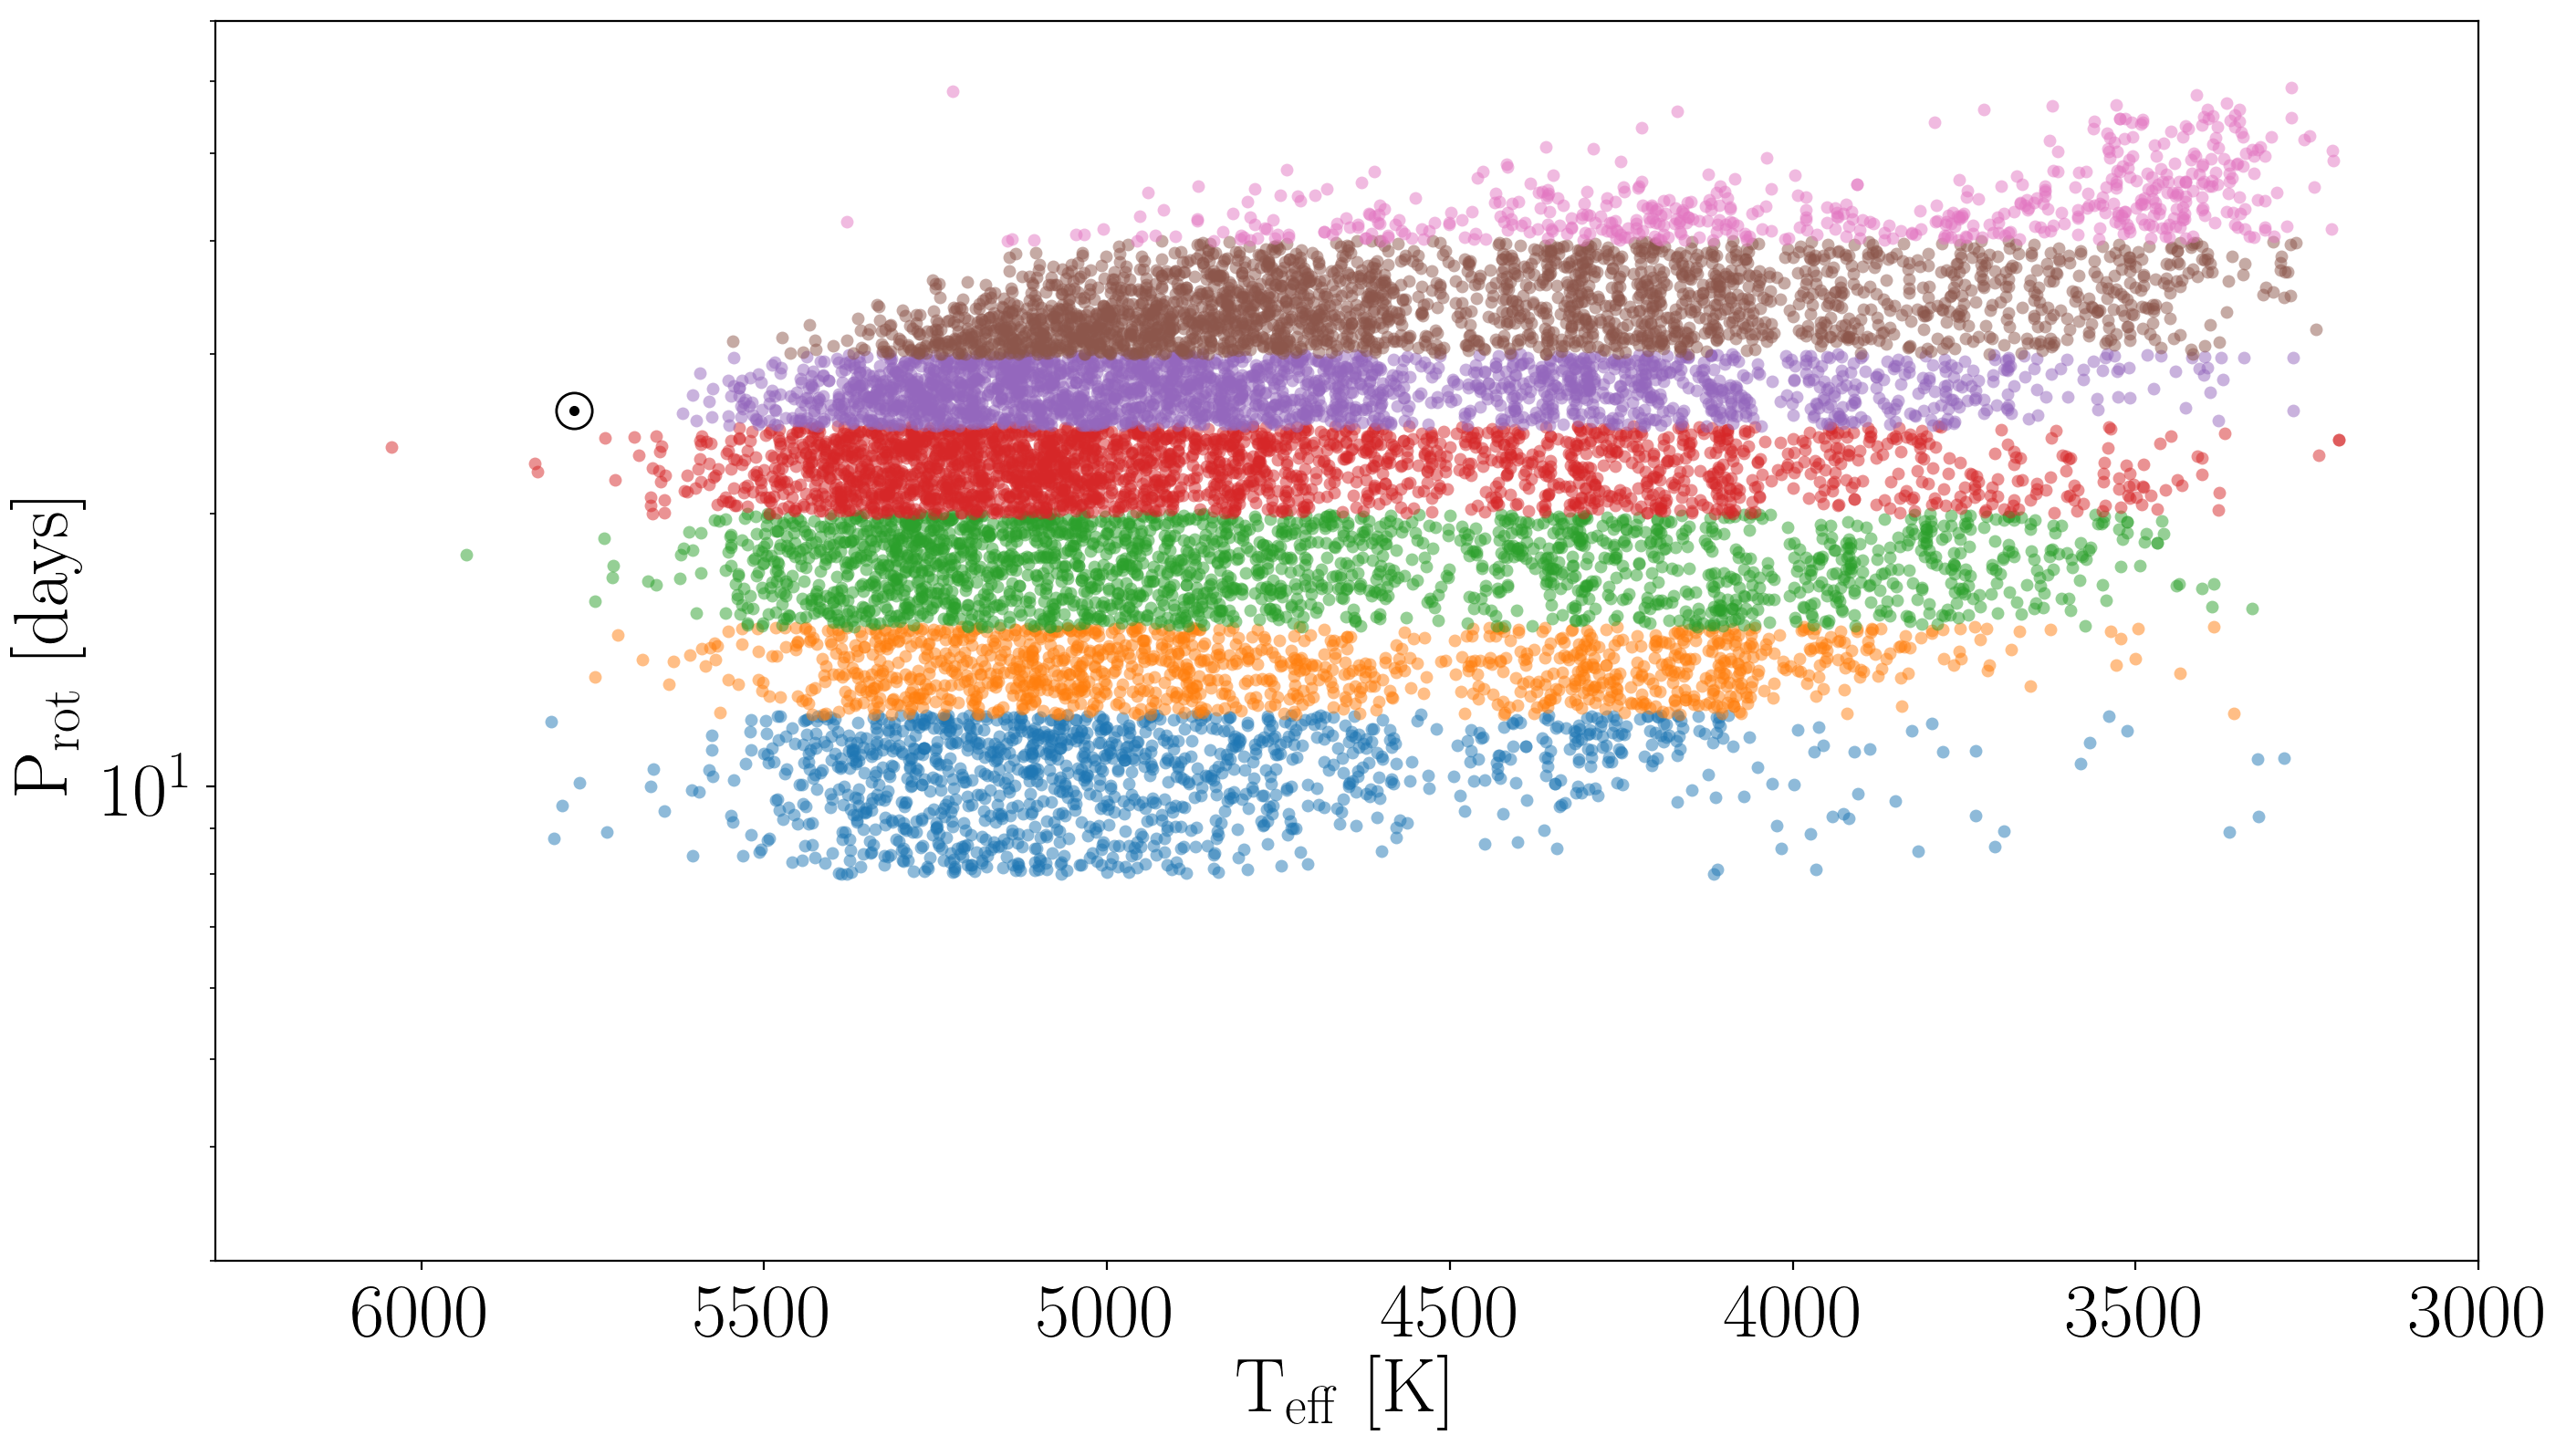

In [32]:
plt.figure(figsize=(16, 9), dpi=200)
for i in range(len(age_ranges)-1):
    m = (gaia_mc.Prot > age_ranges[i]) * (gaia_mc.Prot < age_ranges[i+1])

    # Selected stars
    plt.plot(gaia_mc.Teff[m], gaia_mc.Prot[m], ".", alpha=.5, zorder=0, mec="none", ms=10,
             label="_nolegend_", rasterized=True)

# Sun
plt.scatter(5778, 26, facecolors='w', edgecolors="k", s=200, zorder=3, rasterized=True)
plt.plot(5778, 26, "k.", zorder=3, rasterized=True)
    
plt.xlim(6300, 3000)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.yscale("log")
plt.ylim(3, 70)
# plt.legend()
plt.savefig("prot_cuts")

def plot_step(bins, dbins, teff_ranges):
    plt.figure(figsize=(16, 9), dpi=200)
    for i in range(len(bins)):
        plt.step(bins[i], dbins[i], color="C{}".format(i), where="mid",
                 label="{0} $<$ Teff $<$ {1}".format(teff_ranges[0], teff_ranges[1]))
        plt.errorbar(bins[i], dbins[i], yerr=err[i], fmt=".", color="C{}".format(i), ms=1)
    plt.legend()
    plt.xlabel("$\mathrm{P_{rot}~[days]}$")
    plt.ylabel("$\mathrm{\sigma_{Vb}~[mas/yr]}$")


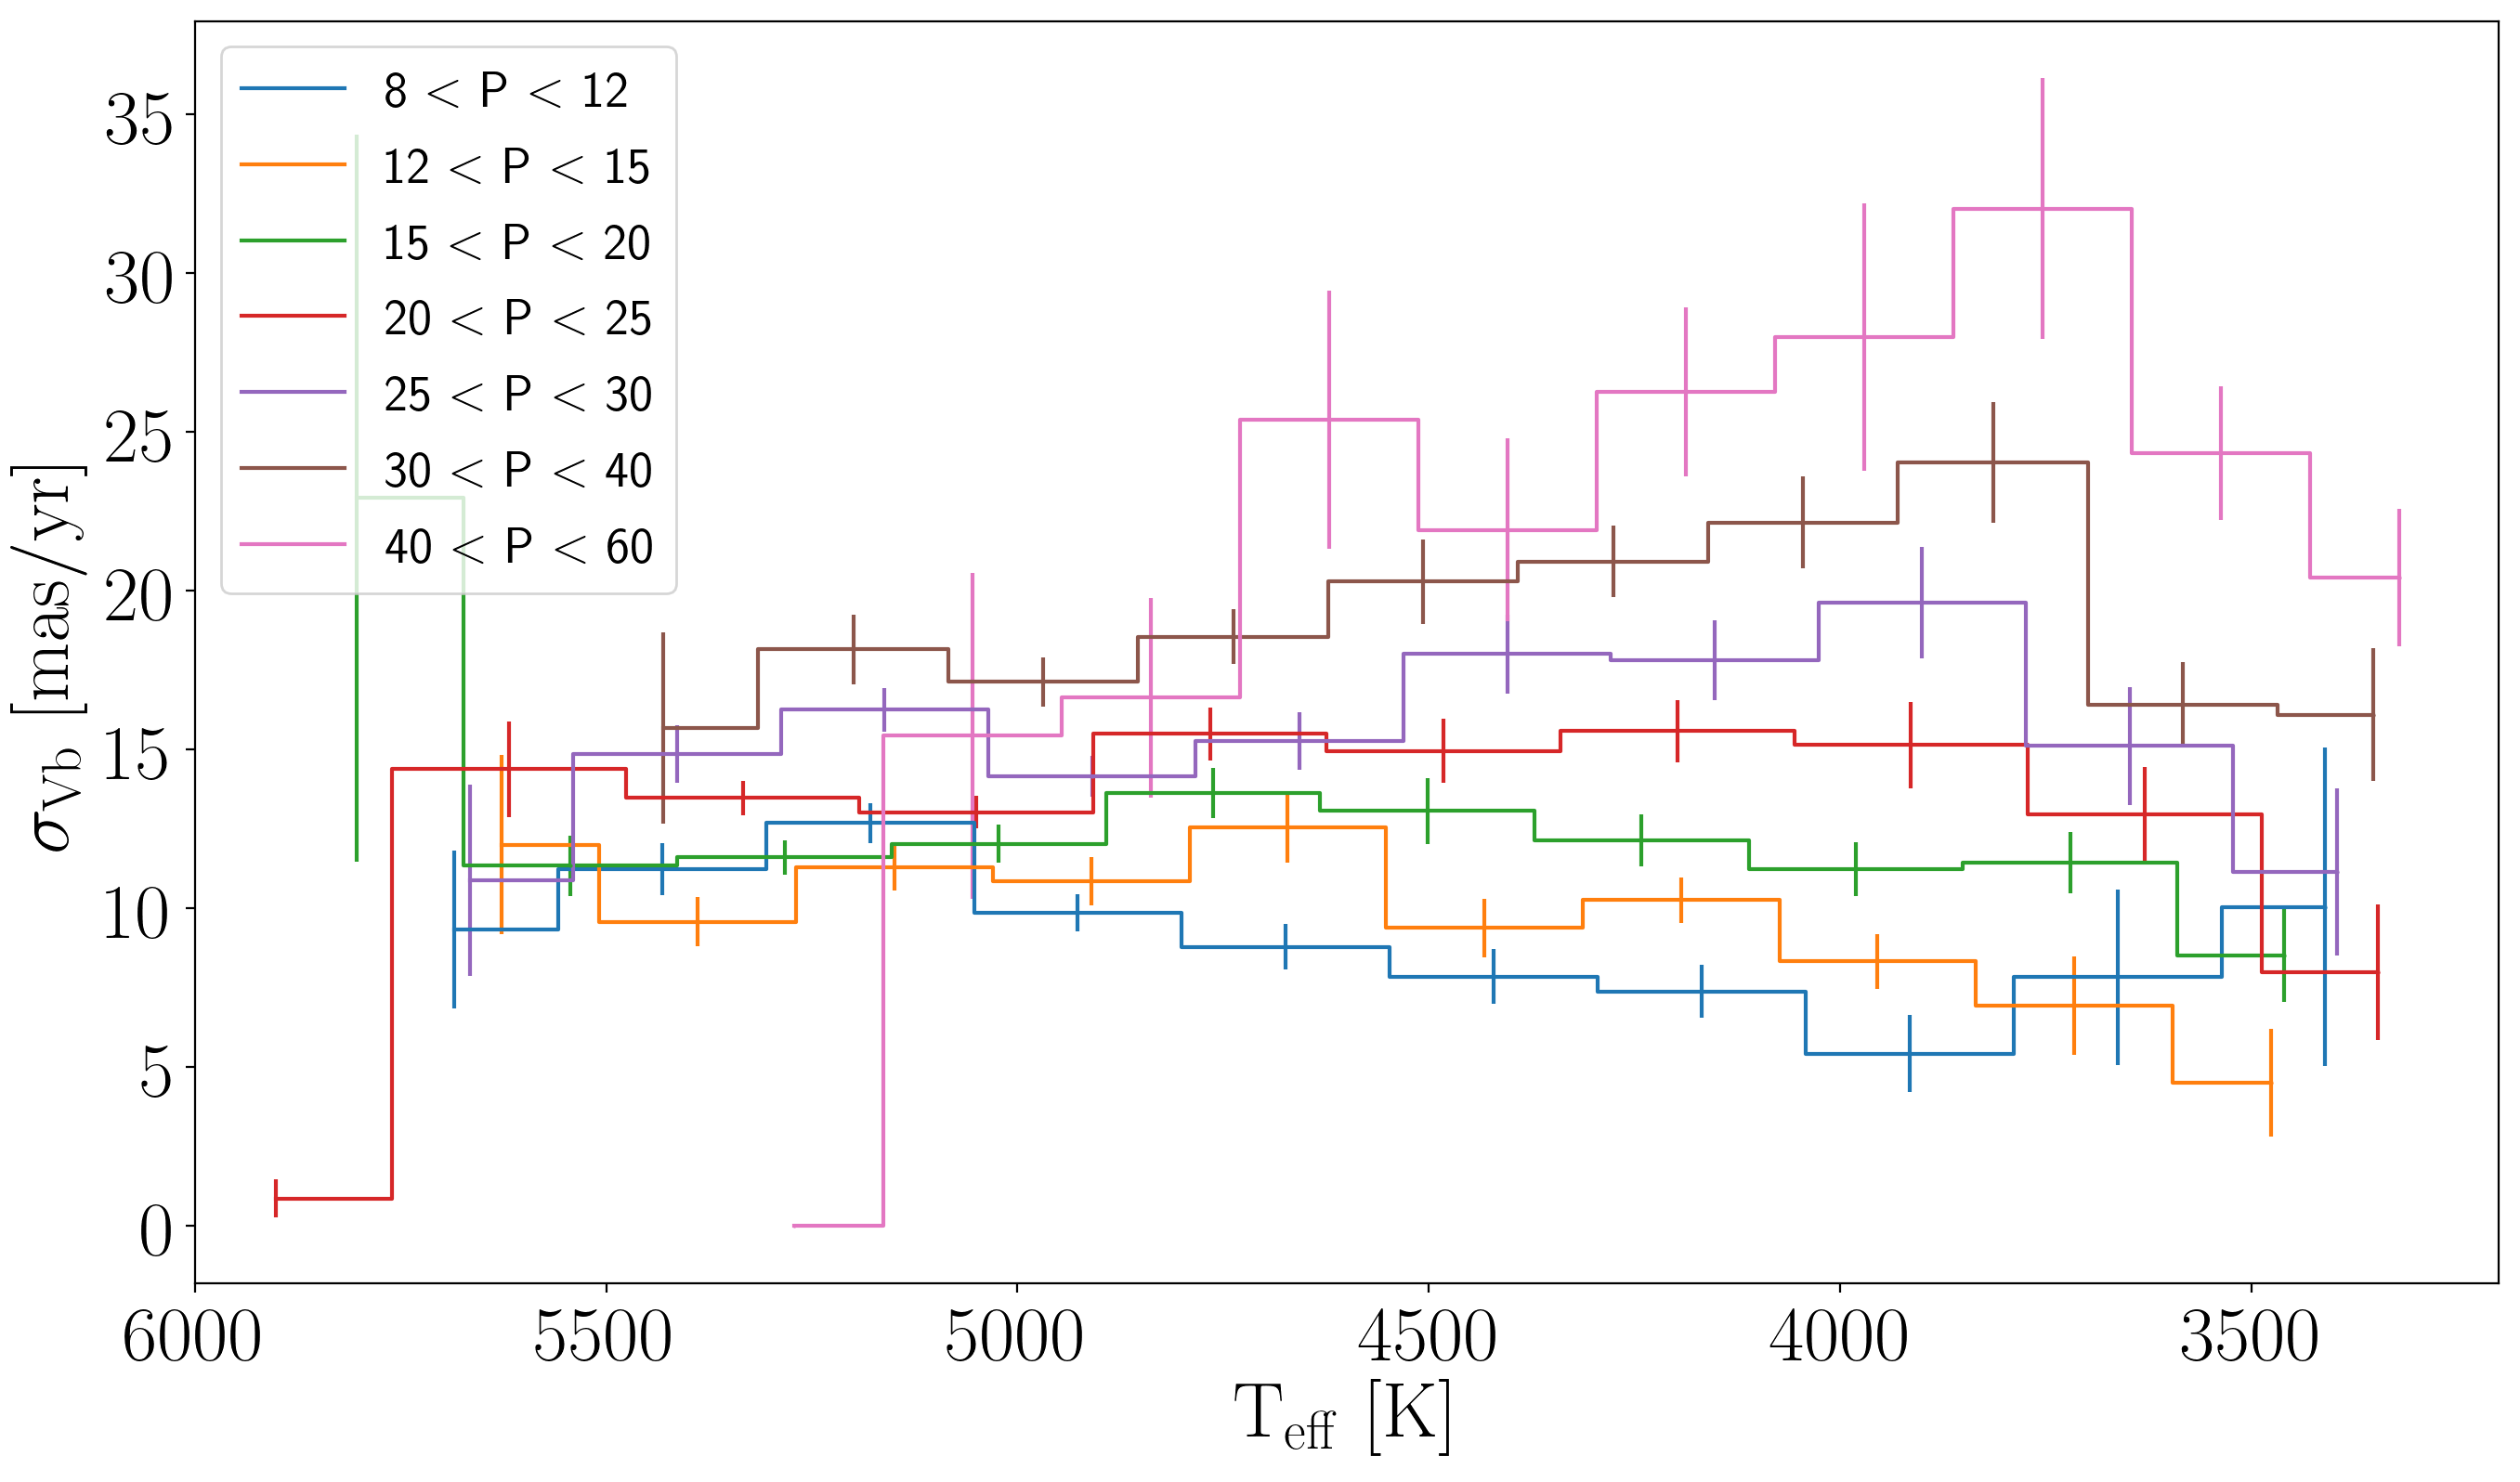

In [30]:
abins0, adbins0, aerr0, amean0 = binned_dispersion(gaia_mc.Teff.values[m0], gaia_mc.v_b.values[m0], 
                                                   nbins=10, method="std")
abins1, adbins1, aerr1, amean1 = binned_dispersion(gaia_mc.Teff.values[m1], gaia_mc.v_b.values[m1], 
                                                   nbins=10, method="std")
abins2, adbins2, aerr2, amean2 = binned_dispersion(gaia_mc.Teff.values[m2], gaia_mc.v_b.values[m2], 
                                                   nbins=10, method="std")
abins3, adbins3, aerr3, amean3 = binned_dispersion(gaia_mc.Teff.values[m3], gaia_mc.v_b.values[m3], 
                                                   nbins=10, method="std")
abins4, adbins4, aerr4, amean4 = binned_dispersion(gaia_mc.Teff.values[m4], gaia_mc.v_b.values[m4], 
                                                   nbins=10, method="std")
abins5, adbins5, aerr5, amean5 = binned_dispersion(gaia_mc.Teff.values[m5], gaia_mc.v_b.values[m5], 
                                                   nbins=10, method="std")
abins6, adbins6, aerr6, amean6 = binned_dispersion(gaia_mc.Teff.values[m6], gaia_mc.v_b.values[m6], 
                                                   nbins=10, method="std")

abins = [abins0, abins1, abins2, abins3, abins4, abins5, abins6]
adbins = [adbins0, adbins1, adbins2, adbins3, adbins4, adbins5, adbins6]
aerr = [aerr0, aerr1, aerr2, aerr3, aerr4, aerr5, aerr6]

plt.figure(figsize=(16, 9), dpi=200)
for i in range(7):
    plt.step(abins[i], adbins[i], color="C{}".format(i), where="mid",
                label="{0} $<$ P $<$ {1}".format(age_ranges[i], age_ranges[i+1]))
    plt.errorbar(abins[i], adbins[i], yerr=aerr[i], fmt=".", color="C{}".format(i), ms=1)
plt.legend()
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{\sigma_{Vb}~[mas/yr]}$")
plt.xlim(6000, 3200)
plt.savefig("age_bins.pdf")
plt.savefig("age_bins")

In [ ]:
from stardate.lhf import gk_rotation_model, gyro_model_rossby

bprp = np.linspace(.56, 2.7, 100)
for a in np.arange(1.06279416, 7, 1):
    logp = gk_rotation_model(np.log10(a*1e9), bprp)
    plt.plot(bprp, 10**logp)
logp = gk_rotation_model(np.log10(.5*1e9), bprp)
plt.plot(bprp, 10**logp)

logp = gk_rotation_model(np.log10(1.65*1e9), bprp)
# plt.plot(bprp, 10**logp, ls="--")